# Coursework 1

This notebook is intended to be used as a starting point for your experiments. The instructions can be found in the MLP2025_26_CW1_Spec.pdf (see Learn,  Assignment Submission, Coursework 1). The methods provided here are just helper functions. If you want more complex graphs such as side by side comparisons of different experiments you should learn more about matplotlib and implement them. Before each experiment remember to re-initialize neural network weights and reset the data providers so you get a properly initialized experiment. For each experiment try to keep most hyperparameters the same except the one under investigation so you can understand what the effects of each are.

## Training Boilerplate

Use the below code as a boilerplate to start your experiments. You can add more cells or change the code as you see fit.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import logging
from typing import Any, Callable, Dict, Optional, Tuple, cast
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from numpy.typing import NDArray
from numpy.random import RandomState
try:
    from IPython import get_ipython  # type: ignore[attr-defined]
except ImportError:
    def get_ipython() -> Any:
        return None
# import sys
# sys.path.append('/path/to/mlpractical')

from mlp.data_providers import DataProvider, MNISTDataProvider, EMNISTDataProvider
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, CustomActivationLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
import mlp.initialisers as init
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule
from mlp.optimisers import Optimiser


In [2]:
%matplotlib inline
plt.style.use('ggplot')

FloatArray = NDArray[np.float64]
IndexArray = NDArray[np.int64]
MonitorFn = Callable[[FloatArray, FloatArray], float]
PlotObjects = Tuple[Figure, Axes]
TrainStats = Tuple[FloatArray, Dict[str, int], float]

def _classification_accuracy(predictions: FloatArray, targets: FloatArray) -> float:
    predicted_labels: IndexArray = cast(IndexArray, predictions.argmax(axis=-1))
    target_labels: IndexArray = cast(IndexArray, targets.argmax(axis=-1))
    return float(np.mean(predicted_labels == target_labels))

def train_model_and_plot_stats(
        model: MultipleLayerModel,
        error: CrossEntropySoftmaxError,
        learning_rule: AdamLearningRule,
        train_data: DataProvider,
        valid_data: Optional[DataProvider],
        num_epochs: int,
        stats_interval: int,
        notebook: bool = True) -> Tuple[FloatArray, Dict[str, int], float, Figure, Axes, Figure, Axes, Figure, Axes]:

    data_monitors: Dict[str, MonitorFn] = {'acc': _classification_accuracy}

    optimiser: Optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors, notebook=notebook)

    train_stats = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
    stats_array, keys, run_time = cast(TrainStats, train_stats)

    fig_1: Figure = plt.figure(figsize=(8, 4))
    ax_1: Axes = fig_1.add_subplot(111)
    epoch_range: IndexArray = np.arange(1, stats_array.shape[0], dtype=np.int64) * stats_interval
    for key in ['error(train)', 'error(valid)']:
        ax_1.plot(epoch_range, stats_array[1:, keys[key]], label=key)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    ax_1.set_ylabel('Error')

    fig_2: Figure = plt.figure(figsize=(8, 4))
    ax_2: Axes = fig_2.add_subplot(111)
    for key in ['acc(train)', 'acc(valid)']:
        ax_2.plot(epoch_range, stats_array[1:, keys[key]], label=key)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    ax_2.set_ylabel('Accuracy')

    grad_plot, grad_ax = cast(PlotObjects, optimiser.plot_grad_flow())

    return (
        stats_array,
        keys,
        run_time,
        fig_1,
        ax_1,
        fig_2,
        ax_2,
        grad_plot,
        grad_ax
    )


In [3]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.

# Seed a random number generator
seed: int = 111020
rng: RandomState = np.random.RandomState(seed)
batch_size: int = 100
# Set up a logger object to print info about the training run to stdout
logger: logging.Logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data: EMNISTDataProvider = EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
valid_data: EMNISTDataProvider = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)


KeysView(NpzFile '/Users/ewkoch/repos/mlp/data/emnist-train.npz' with keys: inputs, targets)
KeysView(NpzFile '/Users/ewkoch/repos/mlp/data/emnist-valid.npz' with keys: inputs, targets)


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

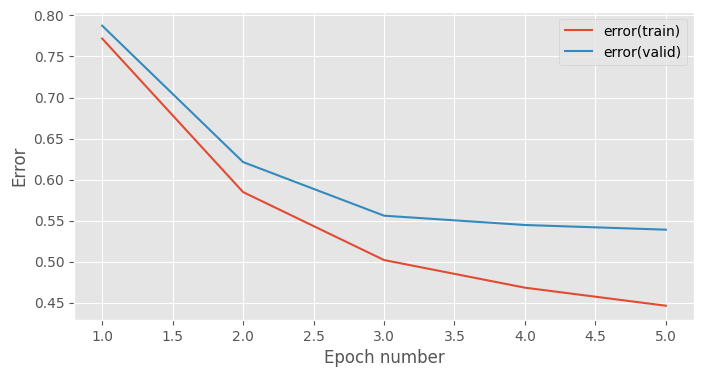

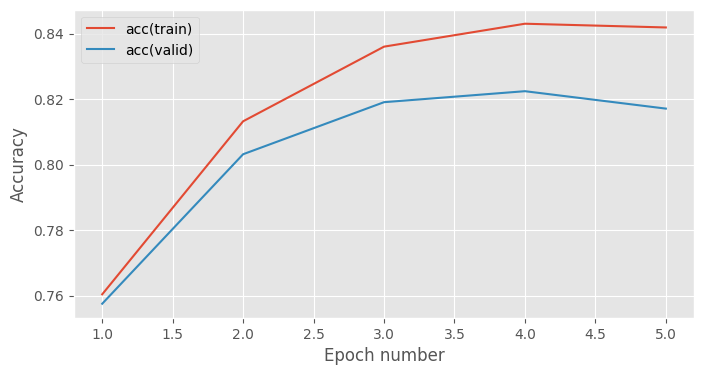

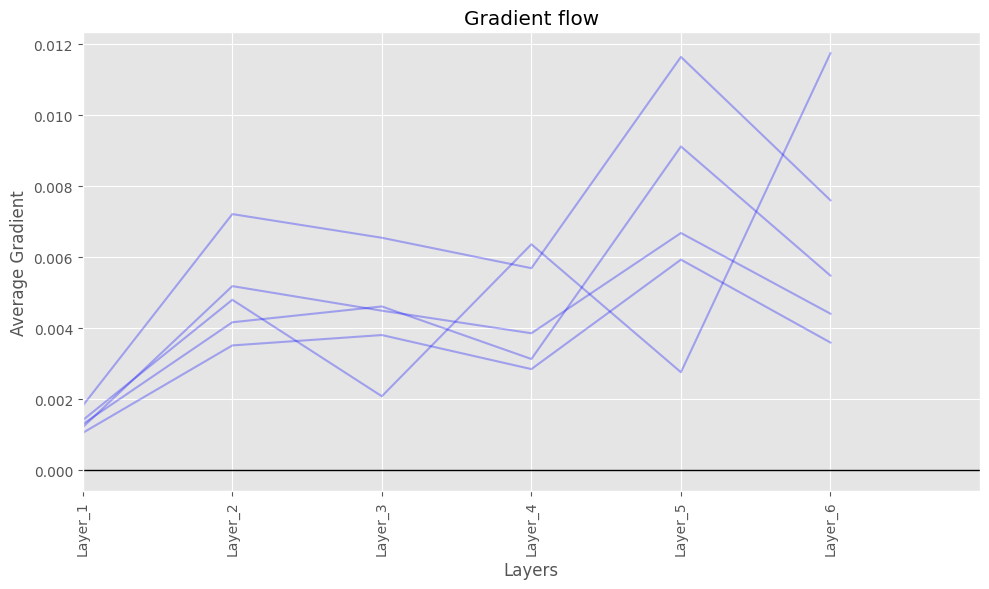

In [4]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

%pip install tqdm

# Setup hyperparameters
learning_rate: float = 0.001
num_epochs: int = 5
stats_interval: int = 1
input_dim: int
output_dim: int
hidden_dim: int
input_dim, output_dim, hidden_dim = 784, 47, 128

weights_init: init.UniformInit = cast(init.UniformInit, GlorotUniformInit(rng=rng))
biases_init: ConstantInit = ConstantInit(0.)

# Create model with TWO hidden layers
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),  # first hidden layer
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),  # second hidden layer
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)  # output layer
])

error: CrossEntropySoftmaxError = CrossEntropySoftmaxError()
# Use an Adam learning rule
learning_rule: AdamLearningRule = AdamLearningRule(learning_rate=learning_rate)

# Remember to use notebook=False when you write a script to be run in a terminal
(
    stats,
    keys,
    run_time,
    fig_1,
    ax_1,
    fig_2,
    ax_2,
    grad_plot,
    grad_ax,
) = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)


## Problematic Training

The following experiments show a failed training run. Run the code and investigate the reasons.

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

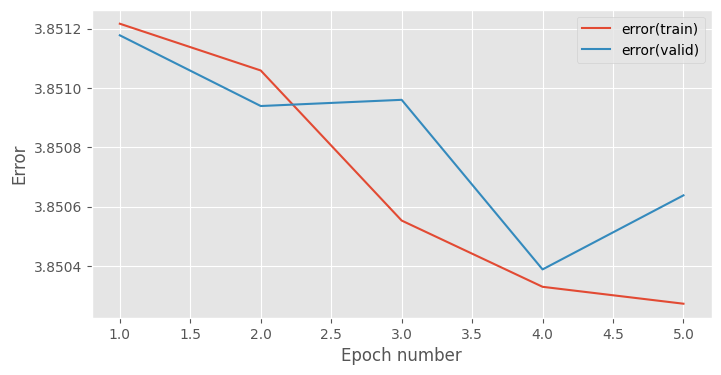

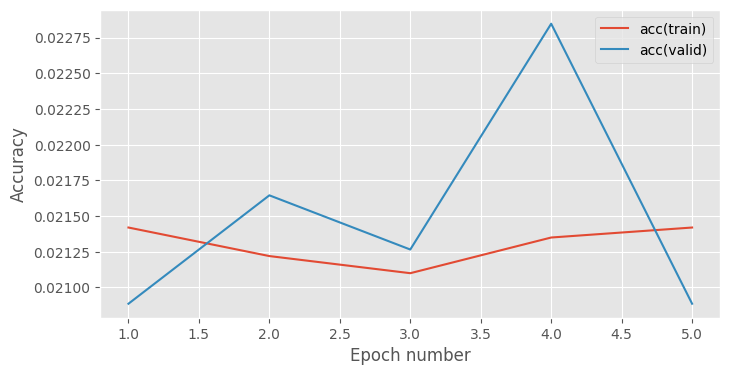

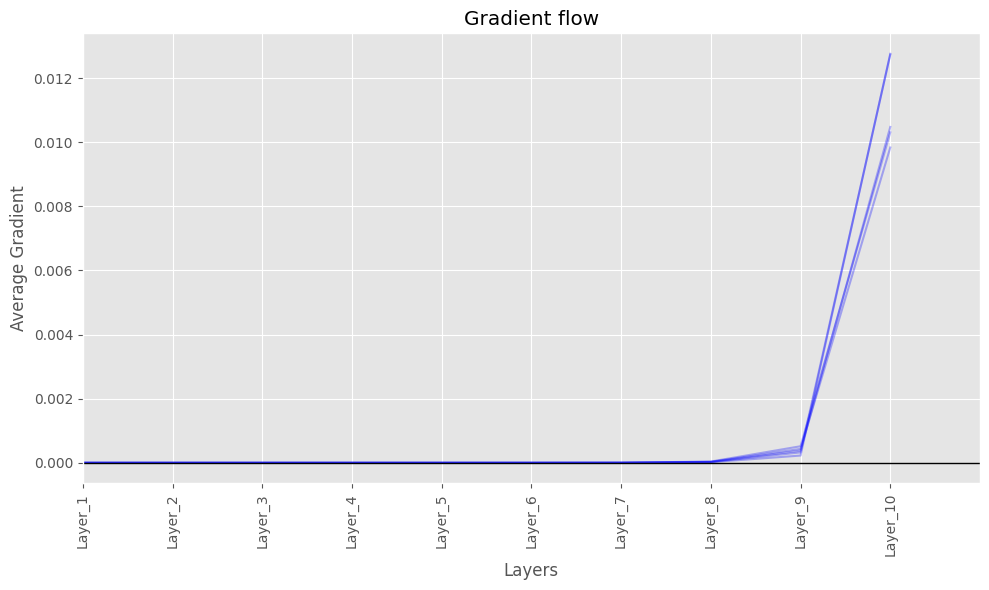

In [5]:
# Setup hyperparameters
learning_rate: float = 0.001
num_epochs: int = 5
stats_interval: int = 1
input_dim: int
output_dim: int
hidden_dim: int
input_dim, output_dim, hidden_dim = 784, 47, 128
gradient_scale: float = 0.1

weights_init: init.UniformInit = cast(init.UniformInit, GlorotUniformInit(rng=rng))
biases_init: ConstantInit = ConstantInit(0.)

# Create model with four hidden layer
model = MultipleLayerModel(
    [
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
        CustomActivationLayer(gradient_scale=gradient_scale),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
        CustomActivationLayer(gradient_scale=gradient_scale),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
        CustomActivationLayer(gradient_scale=gradient_scale),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
        CustomActivationLayer(gradient_scale=gradient_scale),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init),  # output layer
    ]
)

error: CrossEntropySoftmaxError = CrossEntropySoftmaxError()
# Use an Adam learning rule
learning_rule: AdamLearningRule = AdamLearningRule(learning_rate=learning_rate)

# Remember to use notebook=False when you write a script to be run in a terminal
(
    stats,
    keys,
    run_time,
    fig_1,
    ax_1,
    fig_2,
    ax_2,
    grad_plot,
    grad_ax,
) = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, notebook=True)

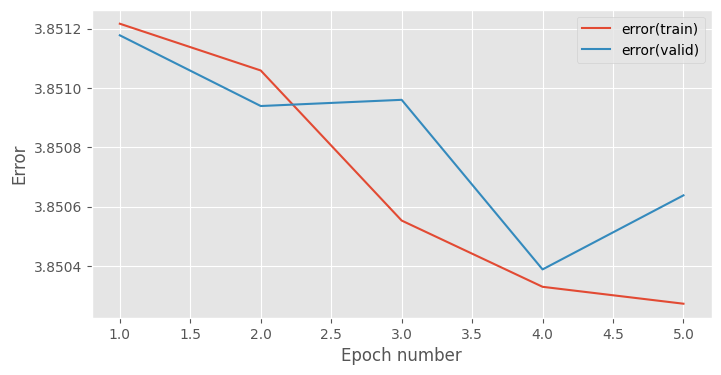

In [6]:
# You can then check the plots like this
fig_1 # The training error plot

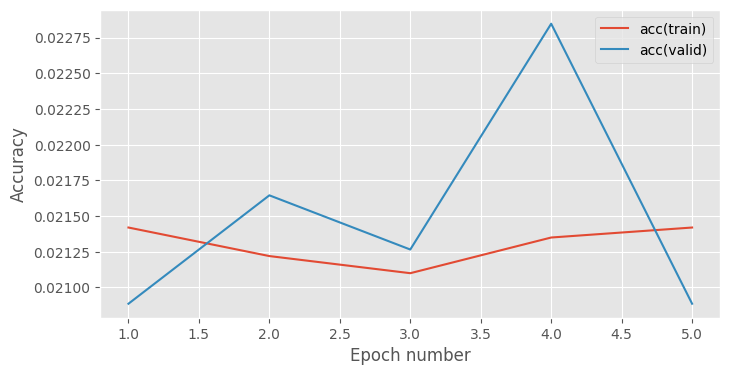

In [7]:
fig_2 # The training accuracy plot

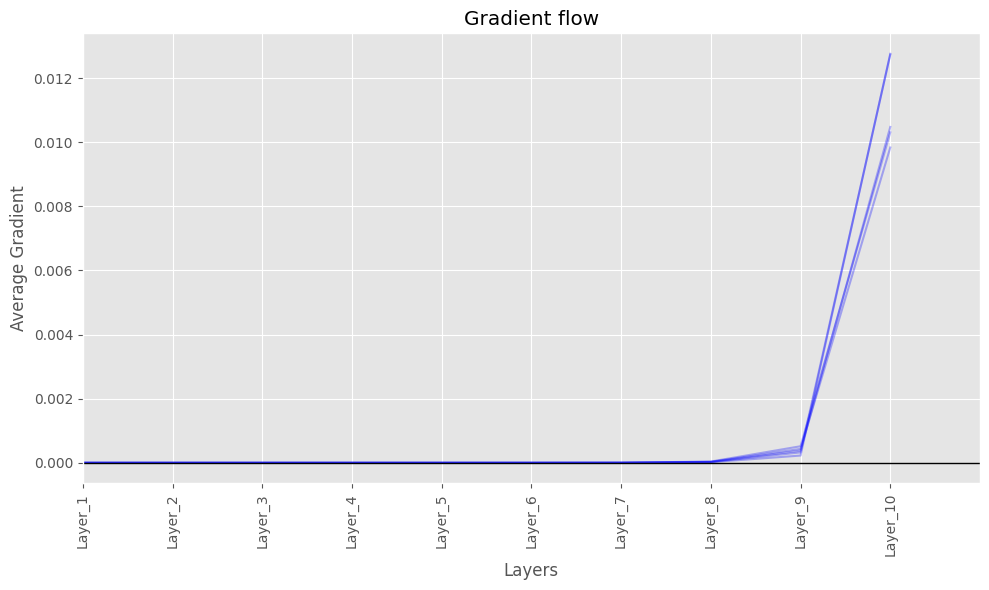

In [8]:
grad_plot # The gradient flow plot

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

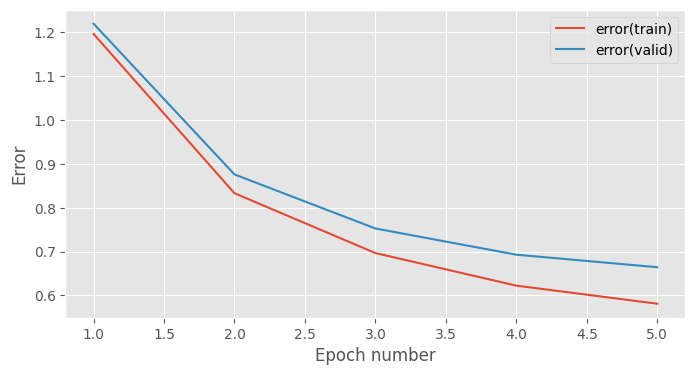

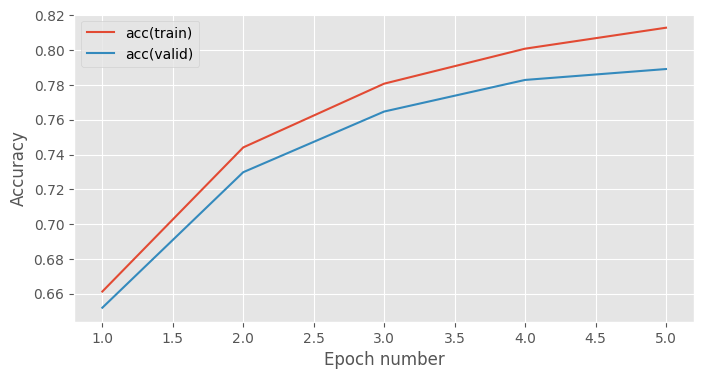

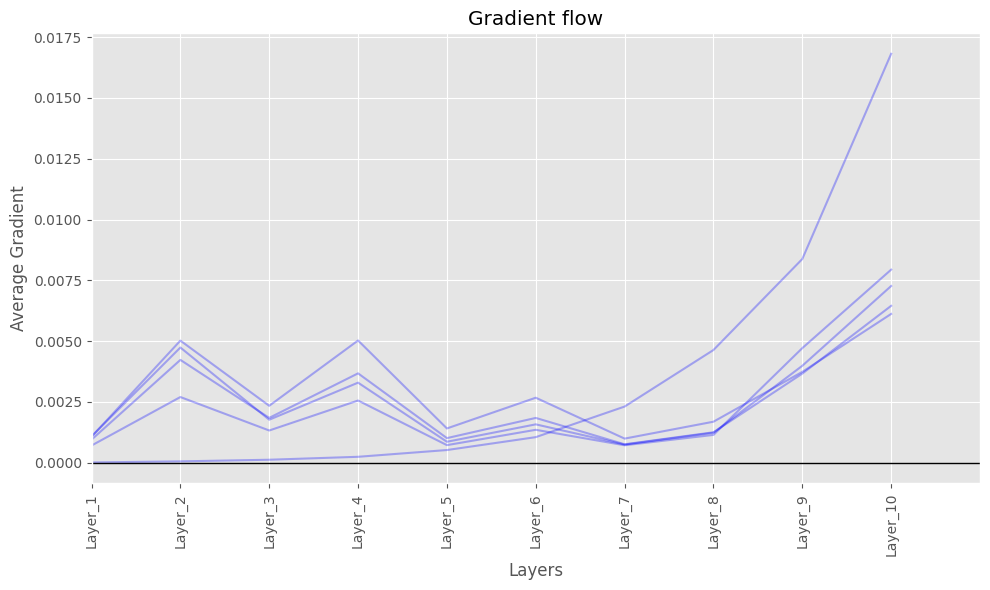

In [9]:
# Setup hyperparameters
learning_rate: float = 0.001
num_epochs: int = 5
stats_interval: int = 1
input_dim: int
output_dim: int
hidden_dim: int
input_dim, output_dim, hidden_dim = 784, 47, 128
gradient_scale: float = 1.0

weights_init: init.UniformInit = cast(init.UniformInit, GlorotUniformInit(rng=rng))
biases_init: ConstantInit = ConstantInit(0.0)

# Create model with four hidden layer
hidden_layer = [
  AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
  CustomActivationLayer(gradient_scale=gradient_scale)
]
model = MultipleLayerModel(
    [
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
        CustomActivationLayer(gradient_scale=gradient_scale),
        *hidden_layer,
        *hidden_layer,
        *hidden_layer,
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init),  # output layer
    ]
)

error: CrossEntropySoftmaxError = CrossEntropySoftmaxError()
# Use an Adam learning rule
learning_rule: AdamLearningRule = AdamLearningRule(learning_rate=learning_rate)

# Remember to use notebook=False when you write a script to be run in a terminal
(
    stats,
    keys,
    run_time,
    fig_1,
    ax_1,
    fig_2,
    ax_2,
    grad_plot,
    grad_ax,
) = train_model_and_plot_stats(
    model,
    error,
    learning_rule,
    train_data,
    valid_data,
    num_epochs,
    stats_interval,
    notebook=True,
)